# Calculate user similarity based on recipes made (or favorited) 

In [3]:
%matplotlib inline 
from sklearn.metrics import jaccard_similarity_score
import pymongo
import math
import collections
import networkx as nx
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, jaccard
from sklearn.feature_extraction import DictVectorizer
import matplotlib.pyplot as plt

client = pymongo.MongoClient("mongodb://localhost/27017/")

ar_db = client.allrecipes

ar_db.collection_names()

[u'recipe_pages',
 u'community_link_pages',
 u'recipes',
 u'member_pages',
 u'members',
 u'webpages',
 u'healthy_recipes',
 u'about',
 u'community_page']

In [4]:
ar_db.members.count()

1430

In [5]:
# Sample a member document
ar_db.members.find_one()

{u'_id': ObjectId('58d1a3f99d477a1e01c32e9f'),
 u'aboutme': {},
 u'favorites_dict': {u'blueberry-crumb-bars': u'10462',
  u'southwestern-pasta-salad': u'26297'},
 u'favorites_recipe_id_list': [u'26297', u'26297', u'10462', u'10462'],
 u'followers_dict': {u'Ariel Penn': u'20455424',
  u'Debra Jenkins Schneider': u'17995663',
  u'Martha Schneider': u'20923340'},
 u'followers_id_list': [u'20923340', u'20455424', u'17995663'],
 u'following_dict': {u'Allrecipes': u'allrecipes',
  u'Martha Schneider': u'20923340'},
 u'following_id_list': [u'20923340', u'allrecipes'],
 u'madeits_dict': {},
 u'madeits_recipe_id_list': [],
 u'member_ID': u'17117019',
 u'nutrition': {u'Calories': {u'25%': 242.25,
   u'50%': 267.5,
   u'75%': 292.75,
   u'count': 2.0,
   u'max': 318.0,
   u'mean': 267.5,
   u'min': 217.0,
   u'std': 71.4177848998413},
  u'Carbs': {u'25%': 31.724999999999998,
   u'50%': 36.25,
   u'75%': 40.77499999999999,
   u'count': 2.0,
   u'max': 45.3,
   u'mean': 36.25,
   u'min': 27.2,
   u

##  Get documents of members that have reviewed a recipe or more 

In [6]:
member_reviews = {a["member_ID"]: a["reviews_dict"] for a in ar_db.members.find(
    {"reviews_dict":{"$not":{"$size":0}}})}

In [7]:
member_reviews.items()[0]

(u'1252111',
 [{u'recipe_ID': u'215026',
   u'recipe_link': u'/recipe/215026/spicy-eggplant/',
   u'recipe_rating': u'5',
   u'recipe_title': u'Spicy Eggplant',
   u'review_text': u'Very tasty!  Made it vegetarian, not vegan, with cheese and milk, but very good.'},
  {u'recipe_ID': u'86602',
   u'recipe_link': u'/recipe/86602/navratan-korma/',
   u'recipe_rating': u'5',
   u'recipe_title': u'Navratan Korma',
   u'review_text': u'Very tasty.  I did saute the onions, celery and carrots in some olive oil first, as suggested.  And I think it could use a touch more seasoning the next time I make it.  I served it over white rice, and everyone had seconds and thirds.'},
  {u'recipe_ID': u'223382',
   u'recipe_link': u'/recipe/223382/chicken-stir-fry/',
   u'recipe_rating': u'5',
   u'recipe_title': u'Chicken Stir-Fry',
   u'review_text': u'A big hit at my Thanksgiving dinner!'}])

In [8]:
# create dict with member, recipe, rating 
memrecrating_dict = [{"member_ID":a, "recipe_ID":b["recipe_ID"],
                      "recipe_rating":float(b["recipe_rating"])} \
                     for a in member_reviews for b in member_reviews[a]]

In [9]:
print "number of recipe reviews:", len(memrecrating_dict)

number of recipe reviews: 7057


In [10]:
memrec_df = pd.DataFrame(memrecrating_dict)

In [11]:
memrec_df.head()

,member_ID,recipe_ID,recipe_rating
0,1252111,215026,5.0
1,1252111,86602,5.0
2,1252111,223382,5.0
3,7869869,216758,5.0
4,4402500,257054,3.0


In [12]:
# # Use sklearn's vectorizer for dicts - "one-hot" representation, not useful.  
# vectorizer = DictVectorizer()

# reviewsarray = vectorizer.fit_transform(memrecrating_dict).toarray()

# reviewsarray.shape

# reviewsarray[1]

In [13]:
collections.Counter([a['recipe_ID'] for a in memrecrating_dict]).most_common()[:200]

[(u'162760', 17),
 (u'6820', 14),
 (u'26317', 14),
 (u'56927', 13),
 (u'8941', 11),
 (u'9023', 11),
 (u'17652', 10),
 (u'16066', 10),
 (u'14231', 10),
 (u'15880', 9),
 (u'7565', 9),
 (u'44742', 9),
 (u'10813', 9),
 (u'17066', 9),
 (u'20171', 9),
 (u'236609', 9),
 (u'10402', 8),
 (u'23600', 8),
 (u'231030', 8),
 (u'6865', 8),
 (u'8694', 8),
 (u'8372', 8),
 (u'222002', 7),
 (u'38425', 7),
 (u'8847', 7),
 (u'220059', 7),
 (u'14685', 7),
 (u'15004', 7),
 (u'213742', 7),
 (u'45954', 7),
 (u'229733', 7),
 (u'70343', 7),
 (u'17691', 7),
 (u'20144', 7),
 (u'7402', 7),
 (u'25642', 7),
 (u'214413', 6),
 (u'51283', 6),
 (u'16700', 6),
 (u'221958', 6),
 (u'15925', 6),
 (u'143082', 6),
 (u'83557', 6),
 (u'16947', 6),
 (u'33385', 6),
 (u'16955', 6),
 (u'54675', 6),
 (u'13116', 6),
 (u'7177', 6),
 (u'14495', 6),
 (u'230816', 6),
 (u'22544', 6),
 (u'10549', 6),
 (u'18906', 6),
 (u'12398', 6),
 (u'26019', 6),
 (u'15093', 6),
 (u'65896', 6),
 (u'10638', 5),
 (u'33474', 5),
 (u'26972', 5),
 (u'92462', 5)

In [14]:
ratings_count = collections.Counter([a['recipe_rating'] for a in memrecrating_dict])
print ratings_count

Counter({5.0: 4772, 4.0: 1553, 3.0: 488, 2.0: 149, 1.0: 95})


<Container object of 5 artists>

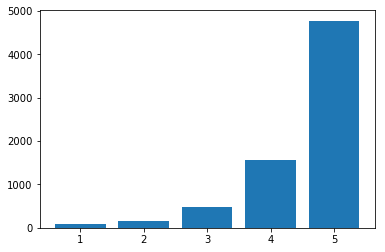

In [15]:
x=[a[0] for a in ratings_count.items()]
y=[a[1] for a in ratings_count.items()]
plt.bar(x,y)

### Ratings are heavily skewed towards favorable.  

In [16]:
(np.asarray(x) * np.asarray(y)).sum()/7057

4.5244438146521189

In [17]:
np.asarray(x).dot(np.asarray(y))/7057

4.5244438146521189

### Create utility matrix

In [19]:
u_matrix = memrec_df.pivot_table(index="member_ID", columns="recipe_ID", values="recipe_rating").fillna(0)

In [20]:
u_matrix.shape

(751, 4835)

In [21]:
u_matrix.head()

recipe_ID,100011,100072,10011,100195,100402,10049,10056,100606,10062,10064,...,9907,99153,99244,9926,99322,9945,9958,9959,99873,9999
member_ID,,,,,,,,,,,,,,,,,,,,,
10090853,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10125683,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1022640,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1031281,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10327182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
(u_matrix>0).sum().sum()

7054

## 7054 ratings over 751 users and 4835 recipes.  Very sparse 

In [23]:
(u_matrix>0).sum().describe()

count    4835.000000
mean        1.458945
std         1.032028
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        17.000000
dtype: float64

In [24]:
(u_matrix.T>0).sum().describe()

count    751.000000
mean       9.392810
std        7.569511
min        1.000000
25%        2.000000
50%        7.000000
75%       18.000000
max       20.000000
dtype: float64

## Average 9.39 ratings per user, 1.46 ratings per recipe 

In [28]:
print "number of recipes with more than one review:",(u_matrix[u_matrix>0].count() > 1).sum()

number of recipes with more than one review: 1398


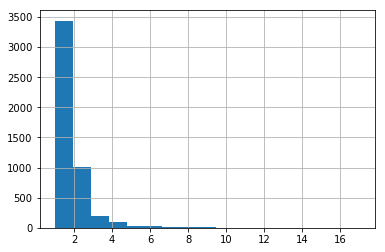

In [39]:
u_matrix[u_matrix>0].count().hist(bins=17)

# Dealing with the sparsity issue: 

- featurize recipe ingredients.  This could be a valid way of characterizing user taste and preference for foods.  
- consolidate user into communities 
- use dimensionality reduction

In [355]:
from scipy import sparse
def get_ratings_data(df): 
    """Turn ratings dataframe into a sparse matrix"""
    member_ids = list(df.member_ID.unique())
    member_len = len(member_ids)
    recipe_ids = list(df.recipe_ID.unique())
    recipe_len = len(recipe_ids)
#    print "lengths:", member_len, recipe_len
    ratings_matrix = sparse.lil_matrix((member_len, recipe_len)) 
#    print ratings_matrix.shape
    for _, row in df.iterrows(): 
#        print _, row
#        print "member_ID:{}, index:{}, recipe_ID:{}, index:{}".format(row.member_ID, member_ids.index(row.member_ID), row.recipe_ID, recipe_ids.index(row.recipe_ID))
        ratings_matrix[member_ids.index(row.member_ID), recipe_ids.index(row.recipe_ID)] = row.recipe_rating
    return member_ids, recipe_ids, ratings_matrix
    

In [356]:
member_ids, recipe_ids, ratings_mat = get_ratings_data(memrec_df)

In [ ]:
# Why is the recipe axis greater than the number of recipes? 

In [132]:
# create a dict with member_ID as key and list of made and "favorited" recipes as value
mem_reclist = {a['member_ID']: a['favorites_recipe_id_list'] + a['madeits_recipe_id_list'] for a in ar_db.members.find()}

In [ ]:
# Create utility matrix 

from scipy import sparse 



In [133]:
# Create set of all recipes
all_recs = set([a for b in mem_reclist.values() for a in b])
print "total number of recipes:", len(all_recs)

total number of recipes: 13173


In [134]:
from sklearn.feature_extraction.text import CountVectorizer

In [136]:
memrec_vectorizerd = CountVectorizer(mem_reclist)

In [ ]:
memrec_vectorizerd.

In [ ]:
# Create edge weights using jaccard similarity of recipes made/favorited 

def member_similarity(X, min_rec_num=5):
    """given a dict of {member_ID:recipes_list}, calculate pairwise 
    similarity.    
    """
    common_set = set.intersection()

In [20]:
G = nx.DiGraph()

In [21]:
G.add_nodes_from(mem_reclist)

In [22]:
print nx.info(G)

Name: 
Type: DiGraph
Number of nodes: 1430
Number of edges: 0
Average in degree:   0.0000
Average out degree:   0.0000


In [23]:
G_ud = nx.Graph()

In [42]:
G.add_nodes_from(mem_reclist, mem_reclist.items())

TypeError: add_nodes_from() takes exactly 2 arguments (3 given)

In [34]:
memswrecs = {a: {"recipes":mem_reclist[a]} for a in  mem_reclist}

In [44]:
G = nx.Graph()

In [45]:
G.add_nodes_from(memswrecs)

In [46]:
G.node.items()[-10:]


[(u'4444341', {}),
 (u'2308478', {}),
 (u'15178027', {}),
 (u'12373662', {}),
 (u'11205760', {}),
 (u'2717927', {}),
 (u'dabratcarol', {}),
 (u'3304107', {}),
 (u'1057997', {}),
 (u'14225928', {})]

In [43]:
G.nodes(data=True)

[(u'11696795', {}),
 (u'9358065', {}),
 (u'6916379', {}),
 (u'3936048', {}),
 (u'17756010', {}),
 (u'15075345', {}),
 (u'20778468', {}),
 (u'861951', {}),
 (u'17180722', {}),
 (u'14286702', {}),
 (u'16914429', {}),
 (u'10779188', {}),
 (u'7353004', {}),
 (u'8231224', {}),
 (u'2690535', {}),
 (u'3700349', {}),
 (u'18159234', {}),
 (u'6026940', {}),
 (u'3645771', {}),
 (u'2175240', {}),
 (u'20252096', {}),
 (u'5639515', {}),
 (u'3681406', {}),
 (u'17441272', {}),
 (u'12760889', {}),
 (u'3437644', {}),
 (u'2191253', {}),
 (u'2943887', {}),
 (u'18101285', {}),
 (u'2437768', {}),
 (u'9367452', {}),
 (u'17796327', {}),
 (u'11666019', {}),
 (u'2541120', {}),
 (u'17505543', {}),
 (u'debbiedoo', {}),
 (u'16496432', {}),
 (u'1945177', {}),
 (u'4846208', {}),
 (u'9522289', {}),
 (u'3144338', {}),
 (u'2169859', {}),
 (u'5360253', {}),
 (u'16425130', {}),
 (u'4181639', {}),
 (u'8722660', {}),
 (u'824077', {}),
 (u'3469144', {}),
 (u'17167863', {}),
 (u'13873095', {}),
 (u'2340061', {}),
 (u'4150065

In [47]:
mem_reclist.items()[1]

(u'9358065',
 [u'15075',
  u'15075',
  u'15174',
  u'15174',
  u'24202',
  u'24202',
  u'15995',
  u'15995',
  u'24094',
  u'24094',
  u'12133',
  u'12133',
  u'15880',
  u'15880',
  u'22544',
  u'22544',
  u'12196',
  u'12196',
  u'234803',
  u'234803',
  u'217922',
  u'217922',
  u'111823',
  u'111823',
  u'20690',
  u'20690',
  u'14685',
  u'14685',
  u'22861',
  u'22861',
  u'154321',
  u'154321',
  u'154851',
  u'154851',
  u'232850',
  u'232850',
  u'239993',
  u'239993',
  u'180118',
  u'180118',
  u'26317',
  u'58942',
  u'12377',
  u'22544',
  u'12196',
  u'24094',
  u'15880',
  u'15075',
  u'24202',
  u'20144',
  u'14685',
  u'236274',
  u'229780',
  u'228283',
  u'237140',
  u'25225',
  u'13353',
  u'51013',
  u'85452',
  u'51535'])

In [48]:
nx.set_node_attributes(G,'recipes',mem_reclist)

In [49]:
G.node.items()[1]

(u'9358065',
 {'recipes': [u'15075',
   u'15075',
   u'15174',
   u'15174',
   u'24202',
   u'24202',
   u'15995',
   u'15995',
   u'24094',
   u'24094',
   u'12133',
   u'12133',
   u'15880',
   u'15880',
   u'22544',
   u'22544',
   u'12196',
   u'12196',
   u'234803',
   u'234803',
   u'217922',
   u'217922',
   u'111823',
   u'111823',
   u'20690',
   u'20690',
   u'14685',
   u'14685',
   u'22861',
   u'22861',
   u'154321',
   u'154321',
   u'154851',
   u'154851',
   u'232850',
   u'232850',
   u'239993',
   u'239993',
   u'180118',
   u'180118',
   u'26317',
   u'58942',
   u'12377',
   u'22544',
   u'12196',
   u'24094',
   u'15880',
   u'15075',
   u'24202',
   u'20144',
   u'14685',
   u'236274',
   u'229780',
   u'228283',
   u'237140',
   u'25225',
   u'13353',
   u'51013',
   u'85452',
   u'51535']})

In [51]:
G_jaccard = list(nx.jaccard_coefficient(G))

In [52]:
G.node.items()[1]

(u'9358065',
 {'recipes': [u'15075',
   u'15075',
   u'15174',
   u'15174',
   u'24202',
   u'24202',
   u'15995',
   u'15995',
   u'24094',
   u'24094',
   u'12133',
   u'12133',
   u'15880',
   u'15880',
   u'22544',
   u'22544',
   u'12196',
   u'12196',
   u'234803',
   u'234803',
   u'217922',
   u'217922',
   u'111823',
   u'111823',
   u'20690',
   u'20690',
   u'14685',
   u'14685',
   u'22861',
   u'22861',
   u'154321',
   u'154321',
   u'154851',
   u'154851',
   u'232850',
   u'232850',
   u'239993',
   u'239993',
   u'180118',
   u'180118',
   u'26317',
   u'58942',
   u'12377',
   u'22544',
   u'12196',
   u'24094',
   u'15880',
   u'15075',
   u'24202',
   u'20144',
   u'14685',
   u'236274',
   u'229780',
   u'228283',
   u'237140',
   u'25225',
   u'13353',
   u'51013',
   u'85452',
   u'51535']})

In [77]:
mems_df = pd.DataFrame(memswrecs).T

In [78]:
mems_df.columns.names = ["member"]

In [79]:
mems_df.head()

member,recipes
10090853,"[25830, 25830, 72964, 72964, 237678, 237678, 2..."
10106217,"[55860, 55860, 16066, 16066, 24263, 24263, 222..."
10125683,"[18262, 18262, 18234, 18234, 20045, 20045, 172..."
10139280,"[24035, 24035, 231939, 231939, 8771, 8771, 808..."
1022640,"[74037, 74037, 238544, 238544, 53729, 53729, 2..."


In [278]:
mems_df.iterrows().next()

(u'10090853', member
 recipes    [25830, 25830, 72964, 72964, 237678, 237678, 2...
 Name: 10090853, dtype: object)

In [82]:
mems_df.describe()

member,recipes
count,1430
unique,1255
top,[]
freq,138


In [93]:
import collections

In [ ]:
import tim

In [105]:
collections.Counter(mems_df['recipes']).most_common()[:10]

TypeError: unhashable type: 'list'

In [99]:
mems_df.index

Index([u'10090853', u'10106217', u'10125683', u'10139280', u'1022640',
       u'1031281', u'10327182', u'10331900', u'10362783', u'1040418',
       ...
       u'supernaturalfan', u'susiewixon', u'sweetsavouryfoodie', u'szyq11',
       u't1ina', u'thechefsisters', u'theempathiccook', u'vabluegrass',
       u'whitwhit', u'youonlyliveonce'],
      dtype='object', length=1430)

In [111]:
mems_np = np.asarray(mems_df)